# Inspect and tweak NIRSpec master background

This version uses the [Altair visualization library](https://altair-viz.github.io). Altair seems to prefer pandas dataframes, so we'll try working that way. Not sure this is a good fit for collections of spectra though.

The goal of this notebook is to provide interactive widgets to users to help them evaluate whether their NIRSpec master background subtraction is any good. Possible problems include:

 - The background is varying spatially across the detector (so a single average isn't good)
 - The wavelengths aren't lining up
 - There are some sources in some of the background aperture
 - There is some contamination from open shutters affecting background apertures
 
Tools might include:

 1. A widget to let the user step through individual background spectra (1D). 
 2. Statistics on the individual background spectra to identify outliers
     1. basic stats could be in an array, to allow numpy tools to work on them
 3. Visualization of mean (over $\lambda$) background (or background over a wavelength region) vs. position on the detector
 4. 2d view where each row (or tile of identical rows for visualization) is a single background 1D spectrum and the columns are just ID numbers. Outliers will be very easy to see in this representation. A widget would allow the user to get the IDs or simply mark the outliers for rejection before re-estimating the master background.
 5. A tool to make customized master backgrounds associating certain background apertures with certain sources.
 
Not sure about architecture, but it might be simplest for the user if all the background tools are in one package. Possibly as a class. I'll pretend it's that way. Then the calls to the steps above might be one-liners after reading the data into the class:

```
from jwsttools import MOSMasterBackground

bkgtool = MOSMasterBackground(filename) # or MOSMasterBackground(x1d or x2d datamodel)
bkgtool.plot1Dwidget() # For item (1)
```

We'll probably want a fair amount of metadata associated with each background spectrum: some sort of ID, positions in various coordinates, exposure time, time of year, price of eggs in China...


In [132]:
# In Jupyterlab
import altair as alt

In [133]:
from jwst import datamodels
from astropy.io import fits
import numpy as np
import specutils
from specutils import Spectrum1D, SpectrumList
from astropy import nddata
import astropy.units as u
from scipy import interpolate
import pandas as pd
from astropy.table import Table

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

## Which data set to use?

The one in box only has a few slits, so maybe isn't the best example:

  - https://stsci.box.com/shared/static/v1h9jpg24rusalpui2jpqyldlrqjmv7k.fits

The following has 71 slits:

  - F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_x1d.fits
  - You can find on box at https://stsci.box.com/v/x1dhackdayfeb18
  
No guarantee that `x1d` file format is current though (it almost certainly is not -- opening it fails with the development version of `jwst.datamodels`).

In [135]:
#filename = 'https://stsci.box.com/v/x1dhackdayfeb18'
filename = 'F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_x1d.fits'
hdu = fits.open(filename)
#hdu[1].header
#for i,h in enumerate(hdu[1:-1]):
#   print(i,h.header['SOURCEID'])
print(len(hdu))

74


Read it into a list of Spectrum1D objects

In [136]:
spectrumlist = SpectrumList.read('F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_x1d.fits',format='JWST')

Create a little class to store store the spectrum list and the means, a method to interpolate to a common wavelength grid, and a method to make a 2d stack.

For the Altair version, we will create a dataframe where one column is wavelength and the rest are the spectra interpolated to that wavelength grid. 

In [137]:
class MOSMasterBackground:

    def __init__(self,spectrumlist,hdu):
        self.speclist = spectrumlist
        self.meanbkg = np.array([s.flux.value.mean() for s in self.speclist]) # Remove units for the moment
        self.ra = np.array([h.header['SLIT_RA'] for h in hdu[1:-1]])
        self.dec = np.array([h.header['SLIT_DEC'] for h in hdu[1:-1]])
        self.sourceid = np.array([f"{h.header['SOURCEID']}" for h in hdu[1:-1]])
        self.ttype7 = np.array([h.header['TTYPE7'] for h in hdu[1:-1]])
        self.create_interpolators()
        self.create_pandas_dataframe()
        
    def create_pandas_dataframe(self):
        wavelengths = np.linspace(1.75,2.0,1000)
        self.df = pd.DataFrame(wavelengths,columns=['wavelength'],index=list(wavelengths))
        for sourceid,interpolator in zip(self.sourceid,self.interpolator):
            self.df[sourceid] = interpolator(self.df['wavelength'])
    
    def create_interpolators(self):
        self.interpolator = []
        for s in self.speclist:
            self.interpolator += [interpolate.interp1d(s.spectral_axis.value,s.flux,
                                                       bounds_error=False,fill_value=(0.,0.))]
    def twod_stack(self,wavelengths):
        _stack = np.zeros((len(self.speclist),len(wavelengths)))
        for row,interp in enumerate(self.interpolator):
            _stack[row,:] = interp(wavelengths)
        self.stack = np.repeat(_stack,10,axis=0) # Repeat a few times for visualization

In [149]:
bkg = MOSMasterBackground(spectrumlist,hdu)
# bkg.df # Uncomment to inspect the data frame

## Background 1D inspection widget
This next step would be a widget to allow the user to scrub through the background spectra one by one:

```bkgtool.plot1Dwidget()```

Here's a simple line plot of one background spectrum. It's pannable and zoomable. But we have to select which source ID to plot by hand.

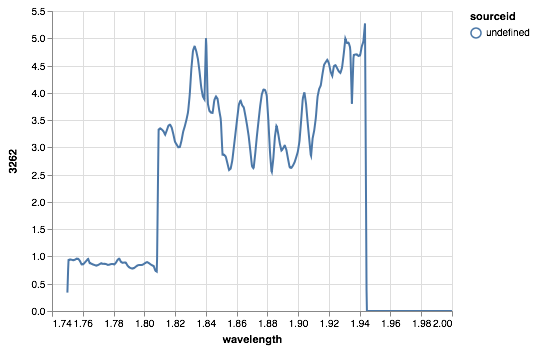

In [140]:
alt.Chart(bkg.df).mark_line().encode(
x='wavelength',
y='3262',
color='sourceid:N').interactive()

Altair has the ability to do some selection, but we need to reformat the dataframe for this to work. The pandas `melt` method takes all the columns and puts them into a single column, in this case with the source ID as an identifier. 

The second line here gets around the Altair limitation of 5000 rows by storing the dataframe to disk.

In [141]:
melted = bkg.df.melt('wavelength',var_name='sourceid', value_name='flux')
alt.data_transformers.enable('json')
#melted

DataTransformerRegistry.enable('json')

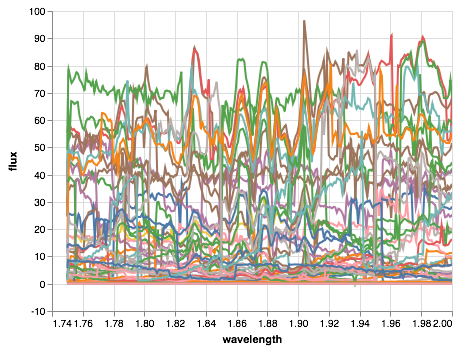

In [142]:
input_dropdown = alt.binding_select(options=list(bkg.sourceid))
selection = alt.selection_single(fields=['sourceid'], bind=input_dropdown, name='Source ID')
color = alt.condition(selection,
                    alt.Color('sourceid:N', legend=None),
                    alt.value('lightgray'))
opacity = alt.condition(selection,alt.value(1.0),alt.value(0.2))
alt.Chart(melted).mark_line().encode(
x='wavelength',
y='flux',
color=color,
opacity=opacity).add_selection(selection).interactive()

In the cell above, you can highlight a single line either by clicking on the line or by selecting the id from the dropdown. 

## Two-panel selection

At this stage, I'd like to create a two-panel plot where the left is points in RA & Dec encoded by mean value (size) and standard deviation (color). Could obviously encode by other quantities. Selection in the left panel highlights the background spectrum in the right panel.

However, this looks like it requires a lot more wrangling to get RA & Dec into the Panda's data frame. It's frustrating that Pandas and Altair doesn't have an easier way to deal with metadata associated with each column and with column-oriented series of datasets. 

So give up on that and make a scatter plot of the means and standard deviations of the fluxes and then select based on that plot to highlight the spectra in a separate panel.

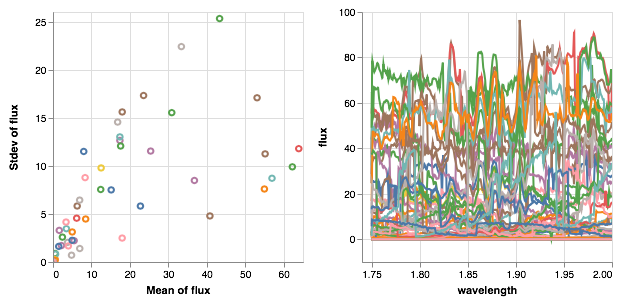

In [144]:
selection = alt.selection_single(fields=['sourceid'])

base = alt.Chart(melted).properties(
    width=250,
    height=250
).add_selection(selection)

color = alt.condition(selection,
                    alt.Color('sourceid:N', legend=None),
                    alt.value('lightgray'))

opacity = alt.condition(selection,alt.value(1.0),alt.value(0.2))

points = base.mark_point().encode(
x='mean(flux)',
y='stdev(flux)',
color=color
).add_selection(selection).interactive()

lines = base.mark_line().encode(
x='wavelength',
y='flux',
color=color,
opacity=opacity).add_selection(selection).interactive()

points | lines